In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import resnet
from tensorflow.keras.applications.resnet50 import preprocess_input

import glob

#need to get 
import os
import shutil

from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.applications.resnet import ResNet152

from keras.applications.resnet import ResNet50
from keras.models import Model
import keras

import tensorflow.keras.applications.densenet as Densenet
from tensorflow.keras.applications.densenet import preprocess_input

from keras.layers import Activation, Dropout, Flatten, Dense, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Sequential,Model,load_model

from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers

import numpy as np
import pandas as pd 

import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping

In [5]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Dec  7 22:47:48 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    26W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Trying Random Oversampling




In [112]:
!mkdir ./OGNetDevelopmentData-2/train_ROS
!mkdir ./OGNetDevelopmentData-2/train_ROS/class_0
!mkdir ./OGNetDevelopmentData-2/train_ROS/class_1

In [ ]:
#https://stackoverflow.com/questions/59952200/move-a-random-sample-of-files-from-one-folder-to-another
import os
import random
import shutil

In [113]:
source = '/content/OGNetDevelopmentData-2/train_images/class_1'
dest = './OGNetDevelopmentData-2/train_ROS/class_1'
#files = os.listdir(source)

filenames = random.choices(os.listdir(source), k=2320) #have to do random.sample because I can get them to go into the folder otherwise

#https://stackoverflow.com/questions/67308631/is-it-possible-to-make-multiple-copies-of-a-file-using-shutil-copy - this is not working perfectly

#oversampling of training positive set
i = 0
for file_name in filenames:
    shutil.copy(os.path.join(source,file_name), os.path.join(dest, f"{i}_1.png"))
    i += 1


In [114]:
 # Source path with original set of images
source = "/content/OGNetDevelopmentData-2/train_images/class_0/*_0.png"
  
# Destination path for 
destination = "/content/OGNetDevelopmentData-2/train_ROS/class_0"
files = glob.glob(source)

# Copy normal images to destination folder

for f in files:
  shutil.copy(f, destination)

In [ ]:
len(filenames)

2320

In [162]:
!ls /content/OGNetDevelopmentData-2/train_ROS/class_1 | wc -l #close enough for now

2320


In [163]:
!ls /content/OGNetDevelopmentData-2/train_ROS/class_0 | wc -l 

5525


In [164]:
batch_size = 64
img_height = 500
img_width = 500

In [165]:
#this is not a dataframe, it's some sort of an object that points to where the data lives (behaving more like generator)
#https://www.tensorflow.org/tutorials/images/classification
train_ds_f = tf.keras.utils.image_dataset_from_directory(
  '/content/OGNetDevelopmentData-2/train_ROS',
  #validation_split=0.2,
  #subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 7845 files belonging to 2 classes.


NameError: ignored

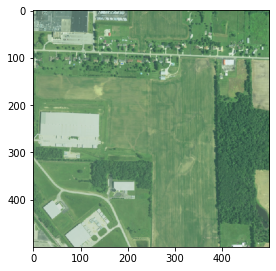

In [134]:
#need to ask about this code below:
plt.figure(figsize=(20, 20))
for images, labels in train_ds_f.take(1):
  for i in range(16):
    x=images
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [166]:
#this is not a dataframe, it's some sort of an object that points to where the data lives (behaving more like generator)
#https://www.tensorflow.org/tutorials/images/classification
val_ds_f = tf.keras.utils.image_dataset_from_directory(
  '/content/OGNetDevelopmentData-2/val_images',
  #validation_split=0.2,
  #subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 708 files belonging to 2 classes.


In [167]:
#this is not a dataframe, it's some sort of an object that points to where the data lives (behaving more like generator)
#https://www.tensorflow.org/tutorials/images/classification
test_ds_f = tf.keras.utils.image_dataset_from_directory(
  '/content/OGNetDevelopmentData-2/test_images',
  #validation_split=0.2,
  #subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 704 files belonging to 2 classes.


In [168]:
size=(224,224)

In [169]:
#from tensorflow
from tensorflow.image import resize
train_ds_f = train_ds_f.map(lambda x, y: (tf.image.resize(x, size), y))
val_ds_f = val_ds_f.map(lambda x, y: (tf.image.resize(x, size), y))
test_ds_f = test_ds_f.map(lambda x, y: (tf.image.resize(x, size), y))


In [170]:
#https://www.tensorflow.org/tutorials/images/classification
AUTOTUNE = tf.data.AUTOTUNE

train_ds_prefetch_f = train_ds_f.cache().prefetch(buffer_size=AUTOTUNE)
val_ds_prefetch_f = val_ds_f.cache().prefetch(buffer_size=AUTOTUNE)
test_ds_prefetch_f = test_ds_f.cache().prefetch(buffer_size=AUTOTUNE)

### ResNets50 (w/Random oversampling)

In [171]:
resnet_preproc_layer = tf.keras.applications.resnet50.preprocess_input
resnet_train_ds_f = train_ds_prefetch_f.map(lambda x, y: (resnet_preproc_layer(x), y))
resnet_val_ds_f =val_ds_prefetch_f.map(lambda x, y: (resnet_preproc_layer(x), y))
resnet_test_ds_f = test_ds_prefetch_f.map(lambda x, y: (resnet_preproc_layer(x), y))

In [172]:
normalization_layer = layers.Rescaling(1./224)
normalized_train_ds_f = resnet_train_ds_f.map(lambda x, y: (normalization_layer(x), y))
normalized_val_ds_f =resnet_val_ds_f.map(lambda x, y: (normalization_layer(x), y))
normalized_test_ds_f = resnet_test_ds_f.map(lambda x, y: (normalization_layer(x), y))

In [ ]:
data_augmentation_adam = keras.Sequential(
    [keras.layers.RandomFlip("horizontal"), keras.layers.RandomRotation(0.1),]
)

In [ ]:
resnet_train_ds_f_aug_adam = train_ds_prefetch_f.map(lambda x, y: (data_augmentation_adam(x), y))


In [ ]:
resnet_train_ds_f_aug_adam = resnet_train_ds_f_aug_adam.map(lambda x, y: (resnet_preproc_layer(x), y))
normalized_train_ds_f_aug_adam = resnet_train_ds_f_aug_adam.map(lambda x, y: (normalization_layer(x), y))

In [ ]:
restnet = ResNet50(include_top=False, weights='imagenet', input_shape=(224,224,3))

output = restnet.layers[-1].output #how does layer work if output isn't defined yet?
output = keras.layers.Flatten()(output)
restnet = Model(restnet.input, output)

for layer in restnet.layers:
    layer.trainable = False

94765736/94765736 [==============================] - 0s 0us/step


In [ ]:
model = Sequential()
model.add(restnet)
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(),
              metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.Recall(), keras.metrics.Precision()])

In [ ]:
model.fit(normalized_train_ds_f_aug_adam,
                    epochs=30, 
                    validation_data=normalized_val_ds_f) #not great performance

Epoch 1/30
246/246 [==============================] - 162s 590ms/step - loss: 0.6654 - binary_accuracy: 0.7289 - recall: 0.4172 - precision: 0.5554 - val_loss: 0.0949 - val_binary_accuracy: 0.9788 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 2/30
246/246 [==============================] - 61s 247ms/step - loss: 0.4946 - binary_accuracy: 0.7665 - recall: 0.5009 - precision: 0.6329 - val_loss: 0.0965 - val_binary_accuracy: 0.9760 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 3/30
246/246 [==============================] - 59s 241ms/step - loss: 0.4537 - binary_accuracy: 0.7871 - recall: 0.5500 - precision: 0.6709 - val_loss: 0.0903 - val_binary_accuracy: 0.9760 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 4/30
246/246 [==============================] - 59s 239ms/step - loss: 0.4521 - binary_accuracy: 0.7927 - recall: 0.5642 - precision: 0.6804 - val_loss: 0.0901 - val_binary_accuracy: 0.9788 - val_recall: 0.0667 - val_precision: 0.5000
Epoch 5/30


In [ ]:
model.evaluate(normalized_val_ds_f)

23/23 [==============================] - 3s 116ms/step - loss: 0.1244 - binary_accuracy: 0.9576 - recall: 0.3333 - precision: 0.2000


[0.12437561899423599,
 0.9576271176338196,
 0.3333333432674408,
 0.20000000298023224]

In [ ]:
model.save('/content/gdrive/MyDrive/resnet_v1')
model.save('/content/gdrive/MyDrive/resnet_v1.h5')

In [ ]:
ROS_model=load_model('/content/gdrive/MyDrive/resnet_v1.h5')

In [ ]:
es2 = EarlyStopping(monitor='val_recall', mode='max', verbose=1, patience=6, restore_best_weights= True)

In [ ]:
history=ROS_model.fit(normalized_train_ds_f_aug_adam,
                    epochs=30, 
                    validation_data=normalized_val_ds_f, callbacks=[es2]) #trying early stopping to catch decent performance before deteriorates

Epoch 1/30
246/246 [==============================] - 61s 230ms/step - loss: 0.3336 - binary_accuracy: 0.8656 - recall: 0.7466 - precision: 0.7880 - val_loss: 0.2452 - val_binary_accuracy: 0.9040 - val_recall: 0.4000 - val_precision: 0.0923
Epoch 2/30
246/246 [==============================] - 58s 236ms/step - loss: 0.3322 - binary_accuracy: 0.8628 - recall: 0.7474 - precision: 0.7797 - val_loss: 0.1120 - val_binary_accuracy: 0.9633 - val_recall: 0.3333 - val_precision: 0.2381
Epoch 3/30
246/246 [==============================] - 57s 232ms/step - loss: 0.3367 - binary_accuracy: 0.8650 - recall: 0.7478 - precision: 0.7854 - val_loss: 0.1027 - val_binary_accuracy: 0.9661 - val_recall: 0.3333 - val_precision: 0.2632
Epoch 4/30
246/246 [==============================] - 65s 264ms/step - loss: 0.3513 - binary_accuracy: 0.8590 - recall: 0.7362 - precision: 0.7757 - val_loss: 0.2133 - val_binary_accuracy: 0.9167 - val_recall: 0.4000 - val_precision: 0.1071
Epoch 5/30
246/246 [================

In [ ]:
ROS_model.save('/content/gdrive/MyDrive/resnet_v2')
ROS_model.save('/content/gdrive/MyDrive/resnet_v2.h5')

In [ ]:
ROS_model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=0.0001),
              metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.Recall(), keras.metrics.Precision()])

In [ ]:
es3 = EarlyStopping(monitor='val_recall_1', mode='max', verbose=1, patience=6, restore_best_weights= True) #make sure to have it restore best weights

In [ ]:
history=ROS_model.fit(normalized_train_ds_f_aug_adam,
                    epochs=30, 
                    validation_data=normalized_val_ds_f, callbacks=[es3]) 

Epoch 1/30
246/246 [==============================] - 57s 230ms/step - loss: 0.2229 - binary_accuracy: 0.9076 - recall_1: 0.8125 - precision_1: 0.8667 - val_loss: 0.2290 - val_binary_accuracy: 0.9068 - val_recall_1: 0.4000 - val_precision_1: 0.0952
Epoch 2/30
246/246 [==============================] - 56s 228ms/step - loss: 0.2160 - binary_accuracy: 0.9089 - recall_1: 0.8220 - precision_1: 0.8633 - val_loss: 0.2544 - val_binary_accuracy: 0.9025 - val_recall_1: 0.4667 - val_precision_1: 0.1029
Epoch 3/30
246/246 [==============================] - 56s 227ms/step - loss: 0.2182 - binary_accuracy: 0.9067 - recall_1: 0.8177 - precision_1: 0.8599 - val_loss: 0.2201 - val_binary_accuracy: 0.9096 - val_recall_1: 0.4000 - val_precision_1: 0.0984
Epoch 4/30
246/246 [==============================] - 56s 229ms/step - loss: 0.2137 - binary_accuracy: 0.9140 - recall_1: 0.8341 - precision_1: 0.8697 - val_loss: 0.2063 - val_binary_accuracy: 0.9181 - val_recall_1: 0.4000 - val_precision_1: 0.1091
Epoc

In [ ]:
ROS_model.save('/content/gdrive/MyDrive/resnet_v3')
ROS_model.save('/content/gdrive/MyDrive/resnet_v3.h5')

In [ ]:
index_array

array([0, 2])

In [ ]:
y_actual = np.concatenate([y for x, y in normalized_val_ds_des], axis=0)

In [ ]:
y_actual.shape

(708,)

In [ ]:
np.unique(y_actual)

array([0, 1], dtype=int32)

In [ ]:
y_prob=full_model.predict(normalized_val_ds_des)

12/12 [==============================] - 4s 174ms/step


In [ ]:
y_prob.shape

(708, 1)

In [ ]:
y_predict = tf.greater(y_prob, .5) #pick threshold for the probability 
y_predict.shape

TensorShape([708, 1])

In [ ]:
np.unique(y_predict) 

array([False,  True])

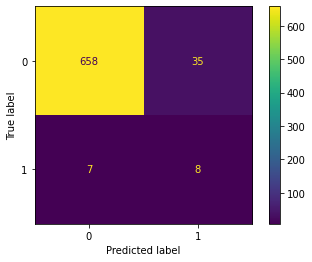

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, plot_confusion_matrix
#class_names = val_ds.class_names
#plt.rcParams.update({'font.size': 16})
con_matrix = confusion_matrix(y_actual, y_predict)
disp = ConfusionMatrixDisplay.from_predictions(y_actual,y_predict,
                               #display_labels=class_names, xticks_rotation = 'vertical'
                               )


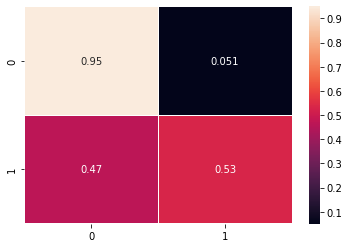

In [ ]:
import seaborn as sns
cm_normalized = con_matrix.astype('float') / con_matrix.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, linewidths = 0.01)


In [ ]:
ROS_model.evaluate(normalized_val_ds_f)

23/23 [==============================] - 3s 113ms/step - loss: 0.2544 - binary_accuracy: 0.9025 - recall_1: 0.4667 - precision_1: 0.1029


[0.25442758202552795,
 0.9025423526763916,
 0.46666666865348816,
 0.10294117778539658]

In [ ]:
data_augmentation = keras.Sequential(
    [keras.layers.RandomFlip("horizontal_and_vertical"), keras.layers.RandomRotation(0.5),
     keras.layers.RandomContrast((0.2,0.2))]
)

In [ ]:
resnet_train_ds_aug = train_ds_prefetch_f.map(lambda x, y: (data_augmentation(x), y))


NameError: ignored

In [ ]:
resnet_train_ds_aug= resnet_train_ds_aug.map(lambda x, y: (resnet_preproc_layer(x), y))
normalized_train_ds_aug = resnet_train_ds_aug.map(lambda x, y: (normalization_layer(x), y))

In [ ]:
es4 = EarlyStopping(monitor='val_recall_2', mode='max', verbose=1, patience=6, restore_best_weights= True)

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(),
              metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.Recall(), keras.metrics.Precision()])

In [ ]:
history_2 = model.fit(normalized_train_ds_aug,
                    epochs=30, 
                    validation_data=normalized_val_ds_f, callbacks= [es4])

Epoch 1/30
246/246 [==============================] - 31s 126ms/step - loss: 0.1438 - binary_accuracy: 0.9440 - recall_2: 0.8961 - precision_2: 0.9130 - val_loss: 0.1652 - val_binary_accuracy: 0.9421 - val_recall_2: 0.4000 - val_precision_2: 0.1579
Epoch 2/30
246/246 [==============================] - 28s 111ms/step - loss: 0.1447 - binary_accuracy: 0.9431 - recall_2: 0.8927 - precision_2: 0.9131 - val_loss: 0.1926 - val_binary_accuracy: 0.9294 - val_recall_2: 0.4000 - val_precision_2: 0.1277
Epoch 3/30
246/246 [==============================] - 28s 114ms/step - loss: 0.1234 - binary_accuracy: 0.9550 - recall_2: 0.9216 - precision_2: 0.9259 - val_loss: 0.2225 - val_binary_accuracy: 0.9124 - val_recall_2: 0.4667 - val_precision_2: 0.1148
Epoch 4/30
246/246 [==============================] - 28s 111ms/step - loss: 0.1127 - binary_accuracy: 0.9592 - recall_2: 0.9241 - precision_2: 0.9371 - val_loss: 0.2510 - val_binary_accuracy: 0.9011 - val_recall_2: 0.5333 - val_precision_2: 0.1127
Epoc

In [ ]:
ROS_model.save('/content/gdrive/MyDrive/resnet_more_aug_1')
ROS_model.save('/content/gdrive/MyDrive/resnet_more_aug_1.h5')

In [178]:
data_augmentation_v2 = keras.Sequential(
    [keras.layers.RandomFlip("horizontal_and_vertical"), keras.layers.RandomRotation(0.2), keras.layers.RandomContrast(0.2)]
)

In [179]:
resnet_train_ds_aug_v2 = train_ds_prefetch_f.map(lambda x, y: (data_augmentation_v2(x), y))


In [180]:
resnet_train_ds_aug_v2 = resnet_train_ds_aug_v2.map(lambda x, y: (resnet_preproc_layer(x), y))
normalized_train_ds_aug_v2 = resnet_train_ds_aug_v2.map(lambda x, y: (normalization_layer(x), y))

In [ ]:
es6 = EarlyStopping(monitor='val_recall_5', mode='max', verbose=1, patience=10, restore_best_weights=True)

In [161]:
history_resnet_aug_v2 = model.fit(normalized_train_ds_aug_v2, epochs=30, validation_data=normalized_val_ds_f, callbacks=[es6])

Epoch 1/30


TypeError: ignored

### ResNet152 (w/Random oversampling)

In [174]:
restnet = ResNet152(include_top=False, weights='imagenet', input_shape=(224,224,3))

output = restnet.layers[-1].output 
output = keras.layers.Flatten()(output)
restnet = Model(restnet.input, output)

for layer in restnet.layers:
    layer.trainable = False

In [175]:
model = Sequential()
model.add(restnet)
model.add(Dense(1, activation='sigmoid'))

In [176]:
model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(),
              metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.Recall(), keras.metrics.Precision()])

In [182]:
repeat_history3 = model.fit(resnet_train_ds_aug_v2,
                    epochs=5, 
                    validation_data=normalized_val_ds_f) 

Epoch 1/5
123/123 [==============================] - 57s 463ms/step - loss: 0.0250 - binary_accuracy: 0.9967 - recall_5: 0.9940 - precision_5: 0.9948 - val_loss: 0.5249 - val_binary_accuracy: 0.9788 - val_recall_5: 0.0000e+00 - val_precision_5: 0.0000e+00
Epoch 2/5
123/123 [==============================] - 59s 477ms/step - loss: 0.0233 - binary_accuracy: 0.9971 - recall_5: 0.9948 - precision_5: 0.9953 - val_loss: 0.5364 - val_binary_accuracy: 0.9788 - val_recall_5: 0.0000e+00 - val_precision_5: 0.0000e+00
Epoch 3/5
123/123 [==============================] - 60s 486ms/step - loss: 0.0263 - binary_accuracy: 0.9971 - recall_5: 0.9944 - precision_5: 0.9957 - val_loss: 0.5800 - val_binary_accuracy: 0.9788 - val_recall_5: 0.0000e+00 - val_precision_5: 0.0000e+00
Epoch 4/5
118/123 [===========================>..] - ETA: 2s - loss: 0.0264 - binary_accuracy: 0.9964 - recall_5: 0.9938 - precision_5: 0.9942

KeyboardInterrupt: ignored

### Xception (w/Random oversampling)

In [183]:
xcept_train_ds_aug_v2 = train_ds_prefetch_f.map(lambda x, y: (data_augmentation_v2(x), y))


In [184]:
xcept_train_ds_aug_v2 = xcept_train_ds_aug_v2.map(lambda x, y: (xcept_preproc_layer(x), y))
normalized_train_ds_aug_v2 = xcept_train_ds_aug_v2.map(lambda x, y: (normalization_layer(x), y))

In [185]:
base_model = keras.applications.Xception(include_top=False,
    weights="imagenet",
    input_shape=(224,224,3))

for layer in base_model.layers: 
    layer.trainable = False

In [186]:
full_model = Sequential()
full_model.add(base_model)
full_model.add(Flatten())
full_model.add(Dense(1, activation='sigmoid'))

In [187]:
full_model.compile(optimizer=keras.optimizers.Adam(), loss='binary_crossentropy', metrics = [keras.metrics.BinaryAccuracy(),keras.metrics.Recall(), keras.metrics.Precision()])

In [188]:
xcept_preproc_layer = tf.keras.applications.xception.preprocess_input
xcept_train_ds = train_ds_prefetch_f.map(lambda x, y: (xcept_preproc_layer(x), y))
xcept_val_ds =val_ds_prefetch_f.map(lambda x, y: (xcept_preproc_layer(x), y))
xcept_test_ds = test_ds_prefetch_f.map(lambda x, y: (xcept_preproc_layer(x), y))

In [189]:
normalization_layer = layers.Rescaling(1./224, offset=-1)
normalized_train_ds_xc = xcept_train_ds.map(lambda x, y: (normalization_layer(x), y))
normalized_val_ds_xc =xcept_val_ds.map(lambda x, y: (normalization_layer(x), y))
normalized_test_ds_xc = xcept_test_ds.map(lambda x, y: (normalization_layer(x), y))

In [191]:
history_xcept_2 = full_model.fit(normalized_train_ds_aug_v2, 
                    epochs=10, 
                    validation_data=normalized_val_ds_xc) 

Epoch 1/10
123/123 [==============================] - 36s 289ms/step - loss: 0.5297 - binary_accuracy: 0.7342 - recall_6: 0.2565 - precision_6: 0.6230 - val_loss: 2.4233 - val_binary_accuracy: 0.0212 - val_recall_6: 1.0000 - val_precision_6: 0.0212
Epoch 2/10
123/123 [==============================] - 34s 276ms/step - loss: 0.4424 - binary_accuracy: 0.7881 - recall_6: 0.4254 - precision_6: 0.7500 - val_loss: 2.6650 - val_binary_accuracy: 0.0212 - val_recall_6: 1.0000 - val_precision_6: 0.0212
Epoch 3/10
123/123 [==============================] - 34s 279ms/step - loss: 0.3990 - binary_accuracy: 0.8178 - recall_6: 0.5272 - precision_6: 0.7865 - val_loss: 2.8468 - val_binary_accuracy: 0.0212 - val_recall_6: 1.0000 - val_precision_6: 0.0212
Epoch 4/10
123/123 [==============================] - 35s 281ms/step - loss: 0.3691 - binary_accuracy: 0.8388 - recall_6: 0.5953 - precision_6: 0.8090 - val_loss: 2.9130 - val_binary_accuracy: 0.0212 - val_recall_6: 1.0000 - val_precision_6: 0.0212
Epoc

KeyboardInterrupt: ignored

### DenseNet (w/Random oversampling)

In [ ]:
#https://www.tensorflow.org/tutorials/images/classification
AUTOTUNE = tf.data.AUTOTUNE

train_ds_prefetch_f = train_ds_f.cache().prefetch(buffer_size=AUTOTUNE)
val_ds_prefetch_f = val_ds_f.cache().prefetch(buffer_size=AUTOTUNE)
test_ds_prefetch_f = test_ds_f.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
desnet_preproc_layer = tf.keras.applications.densenet.preprocess_input
desnet_train_ds = train_ds_prefetch_f.map(lambda x, y: (desnet_preproc_layer(x), y))
desnet_val_ds =val_ds_prefetch_f.map(lambda x, y: (desnet_preproc_layer(x), y))
desnet_test_ds = test_ds_prefetch_f.map(lambda x, y: (desnet_preproc_layer(x), y))

In [ ]:
normalization_layer = layers.Rescaling(1./224, offset=-1)
normalized_train_ds_des = desnet_train_ds.map(lambda x, y: (normalization_layer(x), y))
normalized_val_ds_des =desnet_val_ds.map(lambda x, y: (normalization_layer(x), y))
normalized_test_ds_des = desnet_test_ds.map(lambda x, y: (normalization_layer(x), y))

In [ ]:
densenet_model= tf.keras.applications.DenseNet121(
    include_top=False,
    weights="imagenet",
    input_shape=(224,224,3))

for layer in densenet_model.layers: 
    layer.trainable = False

In [ ]:
full_model = Sequential()
full_model.add(densenet_model)
full_model.add(Flatten())
full_model.add(Dense(1,activation='sigmoid'))

In [ ]:
full_model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 flatten_5 (Flatten)         (None, 50176)             0         
                                                                 
 dense_5 (Dense)             (None, 1)                 50177     
                                                                 
Total params: 7,087,681
Trainable params: 50,177
Non-trainable params: 7,037,504
_________________________________________________________________


In [ ]:
full_model.compile(optimizer='Adam', loss='binary_crossentropy', metrics = [keras.metrics.BinaryAccuracy(),keras.metrics.Recall(), keras.metrics.Precision()])

In [ ]:
es3 = EarlyStopping(monitor='val_recall', mode='max', verbose=1, patience=6, restore_best_weights=True)

In [ ]:
history_dense_1 = full_model.fit(normalized_train_ds_des,
                    epochs=10, 
                    validation_data=normalized_val_ds_des, callbacks=[es3]) 

Epoch 1/10
123/123 [==============================] - 27s 222ms/step - loss: 0.2957 - binary_accuracy: 0.8783 - recall: 0.7026 - precision: 0.8602 - val_loss: 0.1126 - val_binary_accuracy: 0.9746 - val_recall: 0.3333 - val_precision: 0.3846
Epoch 2/10
 31/123 [======>.......................] - ETA: 18s - loss: 0.2874 - binary_accuracy: 0.8831 - recall: 0.6991 - precision: 0.8643

KeyboardInterrupt: ignored

In [ ]:
data_augmentation_adam = keras.Sequential(
    [keras.layers.RandomFlip("horizontal"), keras.layers.RandomRotation(0.1), keras.layers.RandomContrast(0.1)]
)

In [ ]:
desnet_train_ds_aug_adam = train_ds_prefetch_f.map(lambda x, y: (data_augmentation_adam(x), y))


In [ ]:
desnet_train_ds_aug_adam = desnet_train_ds_aug_adam.map(lambda x, y: (desnet_preproc_layer(x), y))
normalized_train_ds_des_aug_adam = desnet_train_ds_aug_adam.map(lambda x, y: (normalization_layer(x), y))

In [ ]:
history_dense_1_aug = full_model.fit(normalized_train_ds_des_aug_adam,
                    epochs=30, 
                    validation_data=normalized_val_ds_des, callbacks=[es3]) #if I included the callbacks here then I could've saed one of the versions w/recall + precision for val set?

Epoch 1/30
123/123 [==============================] - 28s 226ms/step - loss: 0.1685 - binary_accuracy: 0.9485 - recall: 0.8970 - precision: 0.9265 - val_loss: 0.0940 - val_binary_accuracy: 0.9760 - val_recall: 0.4000 - val_precision: 0.4286
Epoch 2/30
123/123 [==============================] - 27s 219ms/step - loss: 0.1540 - binary_accuracy: 0.9584 - recall: 0.9216 - precision: 0.9369 - val_loss: 0.0922 - val_binary_accuracy: 0.9746 - val_recall: 0.4000 - val_precision: 0.4000
Epoch 3/30
123/123 [==============================] - 27s 221ms/step - loss: 0.1394 - binary_accuracy: 0.9649 - recall: 0.9405 - precision: 0.9409 - val_loss: 0.0882 - val_binary_accuracy: 0.9760 - val_recall: 0.4000 - val_precision: 0.4286
Epoch 4/30
123/123 [==============================] - 27s 220ms/step - loss: 0.1283 - binary_accuracy: 0.9703 - recall: 0.9534 - precision: 0.9465 - val_loss: 0.0844 - val_binary_accuracy: 0.9774 - val_recall: 0.4000 - val_precision: 0.4615
Epoch 5/30
123/123 [================

In [ ]:
history_dense_1_augv2 = full_model.fit(normalized_train_ds_des_aug_adam,
                    epochs=30, 
                    validation_data=normalized_val_ds_des, callbacks=[es3]) #doing early stopping multiple times as it learned

Epoch 1/30
123/123 [==============================] - 27s 221ms/step - loss: 0.1536 - binary_accuracy: 0.9568 - recall: 0.9181 - precision: 0.9346 - val_loss: 0.0994 - val_binary_accuracy: 0.9746 - val_recall: 0.4000 - val_precision: 0.4000
Epoch 2/30
123/123 [==============================] - 27s 220ms/step - loss: 0.1361 - binary_accuracy: 0.9652 - recall: 0.9435 - precision: 0.9391 - val_loss: 0.0894 - val_binary_accuracy: 0.9760 - val_recall: 0.4000 - val_precision: 0.4286
Epoch 3/30
123/123 [==============================] - 26s 214ms/step - loss: 0.1238 - binary_accuracy: 0.9716 - recall: 0.9552 - precision: 0.9490 - val_loss: 0.0867 - val_binary_accuracy: 0.9774 - val_recall: 0.4000 - val_precision: 0.4615
Epoch 4/30
123/123 [==============================] - 26s 214ms/step - loss: 0.1134 - binary_accuracy: 0.9773 - recall: 0.9690 - precision: 0.9550 - val_loss: 0.0849 - val_binary_accuracy: 0.9774 - val_recall: 0.4000 - val_precision: 0.4615
Epoch 5/30
123/123 [================

In [ ]:
es4 = EarlyStopping(monitor='val_recall', mode='max', verbose=1, patience=10, restore_best_weights=True)

In [ ]:
history_dense_1_augv3 = full_model.fit(normalized_train_ds_des_aug_adam,
                    epochs=30, 
                    validation_data=normalized_val_ds_des, callbacks=[es4]) #early stopping on to of the last fit (history_dense_1_augv2), if I understand correctly

Epoch 1/30
123/123 [==============================] - 27s 217ms/step - loss: 0.1359 - binary_accuracy: 0.9658 - recall: 0.9409 - precision: 0.9434 - val_loss: 0.1123 - val_binary_accuracy: 0.9746 - val_recall: 0.5333 - val_precision: 0.4211
Epoch 2/30
123/123 [==============================] - 27s 218ms/step - loss: 0.1209 - binary_accuracy: 0.9741 - recall: 0.9634 - precision: 0.9499 - val_loss: 0.0941 - val_binary_accuracy: 0.9746 - val_recall: 0.4000 - val_precision: 0.4000
Epoch 3/30
123/123 [==============================] - 27s 216ms/step - loss: 0.1098 - binary_accuracy: 0.9771 - recall: 0.9703 - precision: 0.9530 - val_loss: 0.0861 - val_binary_accuracy: 0.9774 - val_recall: 0.4000 - val_precision: 0.4615
Epoch 4/30
123/123 [==============================] - 27s 221ms/step - loss: 0.1011 - binary_accuracy: 0.9811 - recall: 0.9776 - precision: 0.9594 - val_loss: 0.0832 - val_binary_accuracy: 0.9788 - val_recall: 0.3333 - val_precision: 0.5000
Epoch 5/30
123/123 [================

In [ ]:
full_model.save('/content/gdrive/MyDrive/densenet_v1')
full_model.save('/content/gdrive/MyDrive/densenet_v1.h5')
full_model.save_weights('/content/gdrive/MyDrive/densenet_v1_checkpoint_weights')

In [ ]:

ROS_d=load_model('/content/gdrive/MyDrive/densenet_v1')

In [ ]:
es5 = EarlyStopping(monitor='val_recall_1', mode='max', verbose=1, patience=10, restore_best_weights=True)

In [ ]:
ROS_d.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=0.0001), #slower learning rate?
              metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.Recall(), keras.metrics.Precision()])

In [ ]:
history_dense_1_augv4= ROS_d.fit(normalized_train_ds_des_aug_adam,
                                 epochs=30, 
                                 validation_data=normalized_val_ds_des, callbacks=[es5])

Epoch 1/30
123/123 [==============================] - 27s 221ms/step - loss: 0.1169 - binary_accuracy: 0.9802 - recall_1: 0.9797 - precision_1: 0.9546 - val_loss: 0.1279 - val_binary_accuracy: 0.9661 - val_recall_1: 0.5333 - val_precision_1: 0.3200
Epoch 2/30
123/123 [==============================] - 27s 220ms/step - loss: 0.1150 - binary_accuracy: 0.9818 - recall_1: 0.9815 - precision_1: 0.9579 - val_loss: 0.1272 - val_binary_accuracy: 0.9661 - val_recall_1: 0.5333 - val_precision_1: 0.3200
Epoch 3/30
123/123 [==============================] - 27s 218ms/step - loss: 0.1134 - binary_accuracy: 0.9824 - recall_1: 0.9836 - precision_1: 0.9580 - val_loss: 0.1263 - val_binary_accuracy: 0.9661 - val_recall_1: 0.5333 - val_precision_1: 0.3200
Epoch 4/30
123/123 [==============================] - 27s 221ms/step - loss: 0.1119 - binary_accuracy: 0.9825 - recall_1: 0.9836 - precision_1: 0.9584 - val_loss: 0.1254 - val_binary_accuracy: 0.9661 - val_recall_1: 0.5333 - val_precision_1: 0.3200
Epoc

KeyboardInterrupt: ignored

In [ ]:
es6 = EarlyStopping(monitor='val_recall_4', mode='max', verbose=1, patience=10, restore_best_weights=True)

In [ ]:
data_augmentation_v2 = keras.Sequential(
    [keras.layers.RandomFlip("horizontal_and_vertical"), keras.layers.RandomRotation(0.2), keras.layers.RandomContrast(0.2)]
)

In [ ]:
desnet_train_ds_aug_v2 = train_ds_prefetch_f.map(lambda x, y: (data_augmentation_v2(x), y))


In [ ]:
desnet_train_ds_aug_v2 = desnet_train_ds_aug_v2.map(lambda x, y: (desnet_preproc_layer(x), y))
normalized_train_ds_des_aug_v2 = desnet_train_ds_aug_v2.map(lambda x, y: (normalization_layer(x), y))

In [ ]:
history_dense_1_augv5 = full_model.fit(normalized_train_ds_des_aug_v2,
                    epochs=30, 
                    validation_data=normalized_val_ds_des, callbacks=[es6]) 

Epoch 1/30
123/123 [==============================] - 27s 219ms/step - loss: 0.3011 - binary_accuracy: 0.8786 - recall_4: 0.7056 - precision_4: 0.8589 - val_loss: 0.1001 - val_binary_accuracy: 0.9760 - val_recall_4: 0.2667 - val_precision_4: 0.4000
Epoch 2/30
123/123 [==============================] - 26s 207ms/step - loss: 0.2615 - binary_accuracy: 0.8984 - recall_4: 0.7621 - precision_4: 0.8783 - val_loss: 0.0882 - val_binary_accuracy: 0.9788 - val_recall_4: 0.3333 - val_precision_4: 0.5000
Epoch 3/30
123/123 [==============================] - 26s 208ms/step - loss: 0.2310 - binary_accuracy: 0.9152 - recall_4: 0.8086 - precision_4: 0.8946 - val_loss: 0.0861 - val_binary_accuracy: 0.9788 - val_recall_4: 0.4000 - val_precision_4: 0.5000
Epoch 4/30
123/123 [==============================] - 26s 210ms/step - loss: 0.2066 - binary_accuracy: 0.9293 - recall_4: 0.8435 - precision_4: 0.9107 - val_loss: 0.0866 - val_binary_accuracy: 0.9774 - val_recall_4: 0.4000 - val_precision_4: 0.4615
Epoc

In [ ]:
full_model.save('/content/gdrive/MyDrive/densenet_v2')
full_model.save('/content/gdrive/MyDrive/densenet_v2.h5')
full_model.save_weights('/content/gdrive/MyDrive/densenet_v2_checkpoint_weights')

In [ ]:
history_dense_1_augv6 = full_model.fit(normalized_train_ds_des_aug_v2,
                    epochs=30, 
                    validation_data=normalized_val_ds_des, callbacks=[es6]) 

Epoch 1/30
123/123 [==============================] - 27s 219ms/step - loss: 0.2077 - binary_accuracy: 0.9277 - recall_4: 0.8414 - precision_4: 0.9075 - val_loss: 0.1018 - val_binary_accuracy: 0.9746 - val_recall_4: 0.4667 - val_precision_4: 0.4118
Epoch 2/30
123/123 [==============================] - 25s 206ms/step - loss: 0.1793 - binary_accuracy: 0.9406 - recall_4: 0.8784 - precision_4: 0.9172 - val_loss: 0.1070 - val_binary_accuracy: 0.9746 - val_recall_4: 0.4667 - val_precision_4: 0.4118
Epoch 3/30
123/123 [==============================] - 25s 204ms/step - loss: 0.1599 - binary_accuracy: 0.9507 - recall_4: 0.9047 - precision_4: 0.9267 - val_loss: 0.0894 - val_binary_accuracy: 0.9732 - val_recall_4: 0.4000 - val_precision_4: 0.3750
Epoch 4/30
123/123 [==============================] - 26s 209ms/step - loss: 0.1467 - binary_accuracy: 0.9572 - recall_4: 0.9194 - precision_4: 0.9347 - val_loss: 0.0798 - val_binary_accuracy: 0.9788 - val_recall_4: 0.4000 - val_precision_4: 0.5000
Epoc

In [ ]:
full_model.save('/content/gdrive/MyDrive/densenet_v2_1')
full_model.save('/content/gdrive/MyDrive/densenet_v2_1.h5')
full_model.save_weights('/content/gdrive/MyDrive/densenet_v2_1_checkpoint_weights')

In [ ]:
history_dense_1_augv5.history['loss']

[0.3011213541030884,
 0.26145026087760925,
 0.23100131750106812,
 0.20656104385852814,
 0.18651993572711945,
 0.1699010729789734,
 0.15587347745895386,
 0.14383774995803833,
 0.1333751678466797,
 0.1241849884390831,
 0.11604289710521698,
 0.1087769940495491,
 0.10225246101617813]

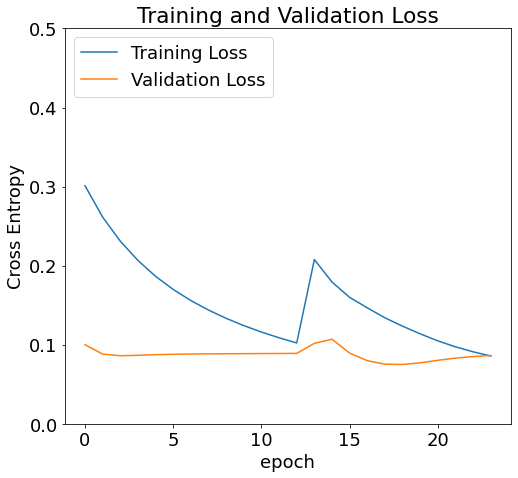

In [ ]:
#https://github.com/xamwood/Metis_Deep_Learning_Project/blob/main/deep_learning_model.ipynb
plt.rcParams.update({'font.size': 18})

loss = history_dense_1_augv5.history['loss'] + history_dense_1_augv6.history['loss']
val_loss = history_dense_1_augv5.history['val_loss'] + history_dense_1_augv6.history['val_loss']

plt.figure(figsize=(8, 16))
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper left')
plt.ylabel('Cross Entropy')
plt.ylim([0,.50])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

#unclear what caused this strange training behavior

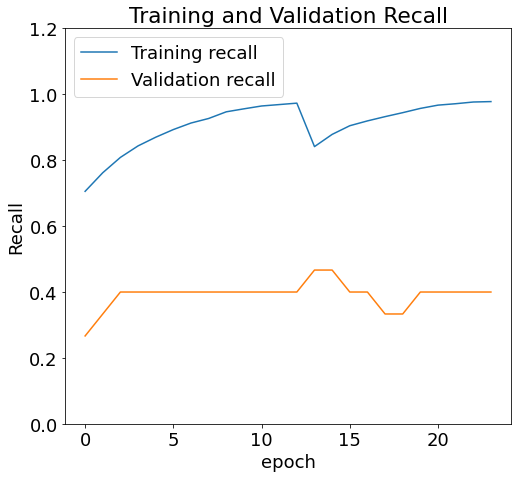

In [ ]:
recall = history_dense_1_augv5.history['recall_4'] + history_dense_1_augv6.history['recall_4']
val_recall = history_dense_1_augv5.history['val_recall_4'] + history_dense_1_augv6.history['val_recall_4']

plt.figure(figsize=(8, 16))
plt.subplot(2, 1, 2)
plt.plot(recall, label='Training recall')
plt.plot(val_recall, label='Validation recall')
plt.legend(loc='upper left')
plt.ylabel('Recall')
plt.ylim([0,1.2])
plt.title('Training and Validation Recall')
plt.xlabel('epoch')
plt.show()

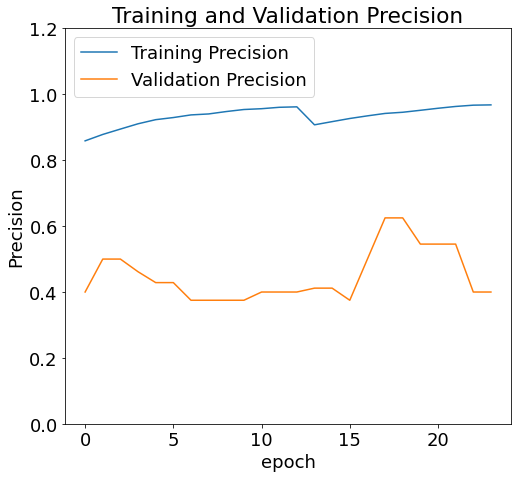

In [ ]:
precision = history_dense_1_augv5.history['precision_4'] + history_dense_1_augv6.history['precision_4']
val_precision = history_dense_1_augv5.history['val_precision_4'] + history_dense_1_augv6.history['val_precision_4']



plt.figure(figsize=(8, 16))
plt.subplot(2, 1, 2)
plt.plot(precision, label='Training Precision')
plt.plot(val_precision, label='Validation Precision')
plt.legend(loc='upper left')
plt.ylabel('Precision')
plt.ylim([0,1.20])
plt.title('Training and Validation Precision')
plt.xlabel('epoch')
#plt.show()
plt.savefig('val_precision.png')

#### Metrics

In [ ]:
full_model.evaluate(normalized_test_ds_des)

11/11 [==============================] - 5s 209ms/step - loss: 0.1007 - binary_accuracy: 0.9659 - recall_4: 0.1000 - precision_4: 0.0625


[0.10072550177574158, 0.9659090638160706, 0.10000000149011612, 0.0625]

In [ ]:
y_actual = np.concatenate([y for x, y in normalized_val_ds_des], axis=0)

In [ ]:
y_actual.shape

(708,)

In [ ]:
np.unique(y_actual)

array([0, 1], dtype=int32)

In [ ]:
y_prob=full_model.predict(normalized_val_ds_des)

12/12 [==============================] - 4s 175ms/step


In [ ]:
y_prob

array([[7.24760070e-02],
       [2.04623360e-02],
       [2.59217974e-02],
       [6.19622460e-03],
       [4.48114760e-02],
       [2.66356692e-02],
       [2.62931529e-02],
       [2.68943131e-01],
       [6.88369945e-03],
       [2.78870631e-02],
       [6.79918751e-02],
       [1.31691182e-02],
       [7.31720626e-02],
       [1.40721388e-02],
       [5.75783215e-02],
       [2.30090823e-02],
       [1.86770782e-02],
       [4.28175628e-02],
       [1.56681135e-03],
       [1.23838648e-01],
       [1.28049422e-02],
       [3.47279222e-03],
       [6.95439428e-03],
       [1.67868659e-01],
       [7.83311799e-02],
       [6.36163592e-01],
       [3.98497749e-03],
       [3.24705504e-02],
       [8.28490183e-02],
       [5.65421287e-05],
       [2.82545630e-02],
       [4.78025147e-04],
       [1.92305213e-03],
       [4.31810990e-02],
       [1.25017678e-02],
       [1.12806022e-01],
       [6.78847870e-03],
       [1.12195238e-07],
       [1.85278952e-02],
       [2.64498666e-02],


In [ ]:
y_prob.shape

(708, 1)

In [ ]:
y_predict = tf.greater(y_prob, .5) #pick threshold for the probability 
y_predict.shape

TensorShape([708, 1])

In [ ]:
np.unique(y_predict) 

array([False,  True])

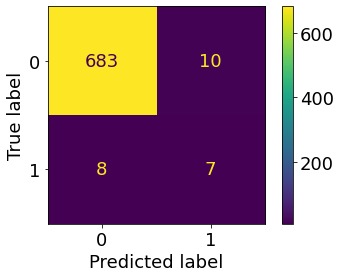

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, plot_confusion_matrix
#class_names = val_ds.class_names
#plt.rcParams.update({'font.size': 16})
con_matrix = confusion_matrix(y_actual, y_predict)
disp = ConfusionMatrixDisplay.from_predictions(y_actual,y_predict,
                               #display_labels=class_names, xticks_rotation = 'vertical'
                               )


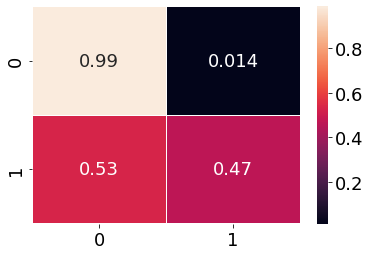

In [ ]:
import seaborn as sns
cm_normalized = con_matrix.astype('float') / con_matrix.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, linewidths = 0.01)

#### Reducing parameters in added layers

In [ ]:
densenet_model= tf.keras.applications.DenseNet121(
    include_top=False,
    weights="imagenet",
    input_shape=(224,224,3))

for layer in densenet_model.layers: 
    layer.trainable = False

29084464/29084464 [==============================] - 0s 0us/step


In [ ]:
full_model = Sequential()
full_model.add(densenet_model)
full_model.add(GlobalAveragePooling2D())
full_model.add(Dense(32, activation='relu'))
full_model.add(Dropout(0.3))
full_model.add(Dense(1,activation='sigmoid'))

In [ ]:
full_model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 global_average_pooling2d_2   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_16 (Dense)            (None, 32)                32800     
                                                                 
 dropout_4 (Dropout)         (None, 32)                0         
                                                                 
 dense_17 (Dense)            (None, 1)                 33        
                                                                 
Total params: 7,070,337
Trainable params: 32,833
Non-trainable params: 7,037,504
_______________________________________

In [ ]:
full_model.compile(keras.optimizers.Adam(learning_rate=0.01), loss='binary_crossentropy', metrics = [keras.metrics.BinaryAccuracy(),keras.metrics.Recall(), keras.metrics.Precision()])

In [ ]:
es7 = EarlyStopping(monitor='val_recall_2', mode='max', verbose=1, patience=6, restore_best_weights=True)

In [ ]:
history_dense_pool = full_model.fit(normalized_train_ds_des_aug_v2,
                    epochs=10, 
                    validation_data=normalized_val_ds_des, callbacks=[es7]) 
#accuracy is really low here even for test set, seems to be underfitting overall w/the pooling method

Epoch 1/10
123/123 [==============================] - ETA: 0s - loss: 0.5701 - binary_accuracy: 0.7050 - recall_3: 0.0026 - precision_3: 1.0000

123/123 [==============================] - 32s 215ms/step - loss: 0.5701 - binary_accuracy: 0.7050 - recall_3: 0.0026 - precision_3: 1.0000 - val_loss: 0.2956 - val_binary_accuracy: 0.9788 - val_recall_3: 0.0000e+00 - val_precision_3: 0.0000e+00
Epoch 2/10
123/123 [==============================] - ETA: 0s - loss: 0.5343 - binary_accuracy: 0.7108 - recall_3: 0.0707 - precision_3: 0.5921

123/123 [==============================] - 25s 204ms/step - loss: 0.5343 - binary_accuracy: 0.7108 - recall_3: 0.0707 - precision_3: 0.5921 - val_loss: 0.3586 - val_binary_accuracy: 0.9732 - val_recall_3: 0.2000 - val_precision_3: 0.3000
Epoch 3/10
123/123 [==============================] - ETA: 0s - loss: 0.5200 - binary_accuracy: 0.7317 - recall_3: 0.3444 - precision_3: 0.5777

123/123 [==============================] - 26s 209ms/step - loss: 0.5200 - binary_accuracy: 0.7317 - recall_3: 0.3444 - precision_3: 0.5777 - val_loss: 0.4639 - val_binary_accuracy: 0.7740 - val_recall_3: 0.6667 - val_precision_3: 0.0606
Epoch 4/10
123/123 [==============================] - ETA: 0s - loss: 0.4918 - binary_accuracy: 0.7604 - recall_3: 0.4767 - precision_3: 0.6242

123/123 [==============================] - 25s 207ms/step - loss: 0.4918 - binary_accuracy: 0.7604 - recall_3: 0.4767 - precision_3: 0.6242 - val_loss: 0.3775 - val_binary_accuracy: 0.8842 - val_recall_3: 0.7333 - val_precision_3: 0.1236
Epoch 5/10
123/123 [==============================] - ETA: 0s - loss: 0.4612 - binary_accuracy: 0.7814 - recall_3: 0.5634 - precision_3: 0.6506

123/123 [==============================] - 25s 206ms/step - loss: 0.4612 - binary_accuracy: 0.7814 - recall_3: 0.5634 - precision_3: 0.6506 - val_loss: 0.2508 - val_binary_accuracy: 0.9336 - val_recall_3: 0.6000 - val_precision_3: 0.1800
Epoch 6/10
123/123 [==============================] - ETA: 0s - loss: 0.4613 - binary_accuracy: 0.7830 - recall_3: 0.6129 - precision_3: 0.6388

123/123 [==============================] - 26s 212ms/step - loss: 0.4613 - binary_accuracy: 0.7830 - recall_3: 0.6129 - precision_3: 0.6388 - val_loss: 0.2836 - val_binary_accuracy: 0.9449 - val_recall_3: 0.6667 - val_precision_3: 0.2273
Epoch 7/10
123/123 [==============================] - ETA: 0s - loss: 0.4431 - binary_accuracy: 0.7899 - recall_3: 0.6349 - precision_3: 0.6478

123/123 [==============================] - 26s 207ms/step - loss: 0.4431 - binary_accuracy: 0.7899 - recall_3: 0.6349 - precision_3: 0.6478 - val_loss: 0.2879 - val_binary_accuracy: 0.8729 - val_recall_3: 0.7333 - val_precision_3: 0.1134
Epoch 8/10
123/123 [==============================] - ETA: 0s - loss: 0.4546 - binary_accuracy: 0.7755 - recall_3: 0.6789 - precision_3: 0.6079

123/123 [==============================] - 25s 204ms/step - loss: 0.4546 - binary_accuracy: 0.7755 - recall_3: 0.6789 - precision_3: 0.6079 - val_loss: 0.2923 - val_binary_accuracy: 0.9294 - val_recall_3: 0.6000 - val_precision_3: 0.1698
Epoch 9/10
123/123 [==============================] - ETA: 0s - loss: 0.4735 - binary_accuracy: 0.7431 - recall_3: 0.6405 - precision_3: 0.5572

123/123 [==============================] - 26s 208ms/step - loss: 0.4735 - binary_accuracy: 0.7431 - recall_3: 0.6405 - precision_3: 0.5572 - val_loss: 0.2494 - val_binary_accuracy: 0.9379 - val_recall_3: 0.6000 - val_precision_3: 0.1915
Epoch 10/10
123/123 [==============================] - ETA: 0s - loss: 0.4585 - binary_accuracy: 0.7489 - recall_3: 0.6897 - precision_3: 0.5614

123/123 [==============================] - 26s 208ms/step - loss: 0.4585 - binary_accuracy: 0.7489 - recall_3: 0.6897 - precision_3: 0.5614 - val_loss: 0.2195 - val_binary_accuracy: 0.9407 - val_recall_3: 0.5333 - val_precision_3: 0.1860


In [ ]:
data_augmentation_adam = keras.Sequential(
    [keras.layers.RandomFlip("horizontal"), keras.layers.RandomRotation(0.1), keras.layers.RandomContrast(0.1)]
)

In [ ]:
desnet_train_ds_aug_adam = train_ds_prefetch_f.map(lambda x, y: (data_augmentation_adam(x), y))


In [ ]:
desnet_train_ds_aug_adam = desnet_train_ds_aug_adam.map(lambda x, y: (desnet_preproc_layer(x), y))
normalized_train_ds_des_aug_adam = desnet_train_ds_aug_adam.map(lambda x, y: (normalization_layer(x), y))

In [ ]:
history_dense_1_aug = full_model.fit(normalized_train_ds_des_aug_adam,
                    epochs=30, 
                    validation_data=normalized_val_ds_des, callbacks=[es3]) #if I included the callbacks here then I could've saed one of the versions w/recall + precision for val set?

Epoch 1/30
123/123 [==============================] - 28s 226ms/step - loss: 0.1685 - binary_accuracy: 0.9485 - recall: 0.8970 - precision: 0.9265 - val_loss: 0.0940 - val_binary_accuracy: 0.9760 - val_recall: 0.4000 - val_precision: 0.4286
Epoch 2/30
123/123 [==============================] - 27s 219ms/step - loss: 0.1540 - binary_accuracy: 0.9584 - recall: 0.9216 - precision: 0.9369 - val_loss: 0.0922 - val_binary_accuracy: 0.9746 - val_recall: 0.4000 - val_precision: 0.4000
Epoch 3/30
123/123 [==============================] - 27s 221ms/step - loss: 0.1394 - binary_accuracy: 0.9649 - recall: 0.9405 - precision: 0.9409 - val_loss: 0.0882 - val_binary_accuracy: 0.9760 - val_recall: 0.4000 - val_precision: 0.4286
Epoch 4/30
123/123 [==============================] - 27s 220ms/step - loss: 0.1283 - binary_accuracy: 0.9703 - recall: 0.9534 - precision: 0.9465 - val_loss: 0.0844 - val_binary_accuracy: 0.9774 - val_recall: 0.4000 - val_precision: 0.4615
Epoch 5/30
123/123 [================

## Trying even larger proportion of Random Oversampling of minority class

In [ ]:
source = '/content/OGNetDevelopmentData-2/train_images/class_1'
dest = './OGNetDevelopmentData-2/train_ROS/class_1'
#files = os.listdir(source)

filenames = random.choices(os.listdir(source), k=3840) #4640 was too much

#https://stackoverflow.com/questions/67308631/is-it-possible-to-make-multiple-copies-of-a-file-using-shutil-copy - this is not working perfectly

i = 0
for file_name in filenames:
    shutil.copy(os.path.join(source,file_name), os.path.join(dest, f"{i}_1.png"))
    i += 1


In [ ]:
 # Source path with original set of images
source = "/content/OGNetDevelopmentData-2/train_images/class_0/*_0.png"
  
# Destination path for 
destination = "/content/OGNetDevelopmentData-2/train_ROS/class_0"
files = glob.glob(source)

# Copy normal images to destination folder

for f in files:
  shutil.copy(f, destination)

In [ ]:
len(filenames)

3840

In [ ]:
!ls /content/OGNetDevelopmentData-2/train_ROS/class_1 | wc -l 

3840


In [ ]:
batch_size = 64  #increased batch size as well
img_height = 500
img_width = 500

In [ ]:
#https://www.tensorflow.org/tutorials/images/classification
train_ds_f = tf.keras.utils.image_dataset_from_directory(
  '/content/OGNetDevelopmentData-2/train_ROS',
  #validation_split=0.2,
  #subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 9365 files belonging to 2 classes.


In [ ]:
#https://www.tensorflow.org/tutorials/images/classification
val_ds_f = tf.keras.utils.image_dataset_from_directory(
  '/content/OGNetDevelopmentData-2/val_images',
  #validation_split=0.2,
  #subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 708 files belonging to 2 classes.


In [ ]:
#https://www.tensorflow.org/tutorials/images/classification
test_ds_f = tf.keras.utils.image_dataset_from_directory(
  '/content/OGNetDevelopmentData-2/test_images',
  #validation_split=0.2,
  #subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 704 files belonging to 2 classes.


In [ ]:
size=(224,224)

In [ ]:
#from tensorflow
from tensorflow.image import resize
train_ds_f = train_ds_f.map(lambda x, y: (tf.image.resize(x, size), y))
val_ds_f = val_ds_f.map(lambda x, y: (tf.image.resize(x, size), y))
test_ds_f = test_ds_f.map(lambda x, y: (tf.image.resize(x, size), y))


In [ ]:
#https://www.tensorflow.org/tutorials/images/classification
AUTOTUNE = tf.data.AUTOTUNE

train_ds_prefetch_f = train_ds_f.cache().prefetch(buffer_size=AUTOTUNE)
val_ds_prefetch_f = val_ds_f.cache().prefetch(buffer_size=AUTOTUNE)
test_ds_prefetch_f = test_ds_f.cache().prefetch(buffer_size=AUTOTUNE)

#### ResNets

In [ ]:
resnet_preproc_layer = tf.keras.applications.resnet50.preprocess_input
resnet_train_ds_f = train_ds_prefetch_f.map(lambda x, y: (resnet_preproc_layer(x), y))
resnet_val_ds_f =val_ds_prefetch_f.map(lambda x, y: (resnet_preproc_layer(x), y))
resnet_test_ds_f = test_ds_prefetch_f.map(lambda x, y: (resnet_preproc_layer(x), y))

In [ ]:
normalization_layer = layers.Rescaling(1./224)
normalized_train_ds_f = resnet_train_ds_f.map(lambda x, y: (normalization_layer(x), y))
normalized_val_ds_f =resnet_val_ds_f.map(lambda x, y: (normalization_layer(x), y))
normalized_test_ds_f = resnet_test_ds_f.map(lambda x, y: (normalization_layer(x), y))

In [ ]:
data_augmentation_adam = keras.Sequential(
    [keras.layers.RandomFlip("horizontal"), keras.layers.RandomRotation(0.1),]
)

In [ ]:
resnet_train_ds_f_aug_adam = train_ds_prefetch_f.map(lambda x, y: (data_augmentation_adam(x), y))


In [ ]:
resnet_train_ds_f_aug_adam = resnet_train_ds_f_aug_adam.map(lambda x, y: (resnet_preproc_layer(x), y))
normalized_train_ds_f_aug_adam = resnet_train_ds_f_aug_adam.map(lambda x, y: (normalization_layer(x), y))

In [ ]:
restnet = ResNet50(include_top=False, weights='imagenet', input_shape=(224,224,3))

output = restnet.layers[-1].output #how does layer work if output isn't defined yet?
output = keras.layers.Flatten()(output)
restnet = Model(restnet.input, output)

for layer in restnet.layers:
    layer.trainable = False

In [ ]:
model = Sequential()
model.add(restnet)
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(),
              metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.Recall(), keras.metrics.Precision()])

In [ ]:
es5 = EarlyStopping(monitor='val_recall_3', mode='max', verbose=1, patience=6, restore_best_weights= True)

In [ ]:
history_3=model.fit(normalized_train_ds_f_aug_adam,
                    epochs=30, 
                    validation_data=normalized_val_ds_f, callbacks=[es5]) # this recall is great but it's basically selecting everything as a 1 b/c precision is so low
#does that mean it's underfitting?

Epoch 1/30
318/318 [==============================] - ETA: 0s - loss: 0.5809 - binary_accuracy: 0.7484 - recall_1: 0.6901 - precision_1: 0.7409

318/318 [==============================] - 160s 452ms/step - loss: 0.5809 - binary_accuracy: 0.7484 - recall_1: 0.6901 - precision_1: 0.7409 - val_loss: 0.7982 - val_binary_accuracy: 0.5424 - val_recall_1: 0.9333 - val_precision_1: 0.0415
Epoch 2/30
318/318 [==============================] - ETA: 0s - loss: 0.3438 - binary_accuracy: 0.8533 - recall_1: 0.8282 - precision_1: 0.8470

318/318 [==============================] - 35s 110ms/step - loss: 0.3438 - binary_accuracy: 0.8533 - recall_1: 0.8282 - precision_1: 0.8470 - val_loss: 0.7002 - val_binary_accuracy: 0.6370 - val_recall_1: 0.7333 - val_precision_1: 0.0417
Epoch 3/30
318/318 [==============================] - ETA: 0s - loss: 0.2797 - binary_accuracy: 0.8925 - recall_1: 0.8808 - precision_1: 0.8833

318/318 [==============================] - 35s 109ms/step - loss: 0.2797 - binary_accuracy: 0.8925 - recall_1: 0.8808 - precision_1: 0.8833 - val_loss: 0.5683 - val_binary_accuracy: 0.7458 - val_recall_1: 0.7333 - val_precision_1: 0.0588
Epoch 4/30
318/318 [==============================] - ETA: 0s - loss: 0.2371 - binary_accuracy: 0.9149 - recall_1: 0.9091 - precision_1: 0.9050

318/318 [==============================] - 35s 110ms/step - loss: 0.2371 - binary_accuracy: 0.9149 - recall_1: 0.9091 - precision_1: 0.9050 - val_loss: 0.4379 - val_binary_accuracy: 0.8023 - val_recall_1: 0.5333 - val_precision_1: 0.0567
Epoch 5/30
286/318 [=========================>....] - ETA: 3s - loss: 0.2056 - binary_accuracy: 0.9321 - recall_1: 0.9324 - precision_1: 0.9203

KeyboardInterrupt: ignored

In [ ]:
#changing the model to add more parameters
model = Sequential()
model.add(restnet)
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(),
              metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.Recall(), keras.metrics.Precision()])

In [ ]:
es5 = EarlyStopping(monitor='val_recall_2', mode='max', verbose=1, patience=6, restore_best_weights= True)

In [ ]:
history_4=model.fit(normalized_train_ds_f_aug_adam,
                    epochs=30, 
                    validation_data=normalized_val_ds_f, callbacks=[es5]) #seems to be bouncing around quite a bit more 

Epoch 1/30
318/318 [==============================] - ETA: 0s - loss: 0.7724 - binary_accuracy: 0.6112 - recall_3: 0.6129 - precision_3: 0.5688

318/318 [==============================] - 40s 115ms/step - loss: 0.7724 - binary_accuracy: 0.6112 - recall_3: 0.6129 - precision_3: 0.5688 - val_loss: 0.4340 - val_binary_accuracy: 0.7514 - val_recall_3: 0.6000 - val_precision_3: 0.0503
Epoch 2/30
318/318 [==============================] - ETA: 0s - loss: 0.6257 - binary_accuracy: 0.6574 - recall_3: 0.5078 - precision_3: 0.6627

318/318 [==============================] - 35s 110ms/step - loss: 0.6257 - binary_accuracy: 0.6574 - recall_3: 0.5078 - precision_3: 0.6627 - val_loss: 0.6249 - val_binary_accuracy: 0.9506 - val_recall_3: 0.1333 - val_precision_3: 0.0833
Epoch 3/30
318/318 [==============================] - ETA: 0s - loss: 0.5975 - binary_accuracy: 0.6984 - recall_3: 0.5099 - precision_3: 0.7492

318/318 [==============================] - 35s 109ms/step - loss: 0.5975 - binary_accuracy: 0.6984 - recall_3: 0.5099 - precision_3: 0.7492 - val_loss: 0.5332 - val_binary_accuracy: 0.9732 - val_recall_3: 0.0667 - val_precision_3: 0.1667
Epoch 4/30
318/318 [==============================] - ETA: 0s - loss: 0.5647 - binary_accuracy: 0.7182 - recall_3: 0.5177 - precision_3: 0.7933

318/318 [==============================] - 35s 109ms/step - loss: 0.5647 - binary_accuracy: 0.7182 - recall_3: 0.5177 - precision_3: 0.7933 - val_loss: 0.5094 - val_binary_accuracy: 0.9181 - val_recall_3: 0.3333 - val_precision_3: 0.0943
Epoch 5/30
318/318 [==============================] - ETA: 0s - loss: 0.5395 - binary_accuracy: 0.7393 - recall_3: 0.5394 - precision_3: 0.8299

318/318 [==============================] - 35s 111ms/step - loss: 0.5395 - binary_accuracy: 0.7393 - recall_3: 0.5394 - precision_3: 0.8299 - val_loss: 0.5047 - val_binary_accuracy: 0.8870 - val_recall_3: 0.4000 - val_precision_3: 0.0779
Epoch 6/30
318/318 [==============================] - ETA: 0s - loss: 0.5104 - binary_accuracy: 0.7620 - recall_3: 0.5675 - precision_3: 0.8647

318/318 [==============================] - 37s 116ms/step - loss: 0.5104 - binary_accuracy: 0.7620 - recall_3: 0.5675 - precision_3: 0.8647 - val_loss: 0.3969 - val_binary_accuracy: 0.9788 - val_recall_3: 0.1333 - val_precision_3: 0.5000
Epoch 7/30
318/318 [==============================] - ETA: 0s - loss: 0.4980 - binary_accuracy: 0.7694 - recall_3: 0.5741 - precision_3: 0.8786

318/318 [==============================] - 35s 109ms/step - loss: 0.4980 - binary_accuracy: 0.7694 - recall_3: 0.5741 - precision_3: 0.8786 - val_loss: 0.4302 - val_binary_accuracy: 0.9181 - val_recall_3: 0.3333 - val_precision_3: 0.0943
Epoch 8/30
318/318 [==============================] - ETA: 0s - loss: 0.4743 - binary_accuracy: 0.7870 - recall_3: 0.6030 - precision_3: 0.8965

318/318 [==============================] - 35s 109ms/step - loss: 0.4743 - binary_accuracy: 0.7870 - recall_3: 0.6030 - precision_3: 0.8965 - val_loss: 0.4139 - val_binary_accuracy: 0.9195 - val_recall_3: 0.3333 - val_precision_3: 0.0962
Epoch 9/30
318/318 [==============================] - ETA: 0s - loss: 0.4601 - binary_accuracy: 0.7969 - recall_3: 0.6116 - precision_3: 0.9152

318/318 [==============================] - 35s 110ms/step - loss: 0.4601 - binary_accuracy: 0.7969 - recall_3: 0.6116 - precision_3: 0.9152 - val_loss: 0.4031 - val_binary_accuracy: 0.9209 - val_recall_3: 0.3333 - val_precision_3: 0.0980
Epoch 10/30
318/318 [==============================] - ETA: 0s - loss: 0.4516 - binary_accuracy: 0.8015 - recall_3: 0.6211 - precision_3: 0.9173

318/318 [==============================] - 35s 109ms/step - loss: 0.4516 - binary_accuracy: 0.8015 - recall_3: 0.6211 - precision_3: 0.9173 - val_loss: 0.5171 - val_binary_accuracy: 0.8277 - val_recall_3: 0.5333 - val_precision_3: 0.0650
Epoch 11/30
318/318 [==============================] - ETA: 0s - loss: 0.4449 - binary_accuracy: 0.8033 - recall_3: 0.6228 - precision_3: 0.9207

KeyboardInterrupt: ignored

#### DenseNets

In [ ]:
desnet_preproc_layer = tf.keras.applications.densenet.preprocess_input
desnet_train_ds = train_ds_prefetch_f.map(lambda x, y: (desnet_preproc_layer(x), y))
desnet_val_ds =val_ds_prefetch_f.map(lambda x, y: (desnet_preproc_layer(x), y))
desnet_test_ds = test_ds_prefetch_f.map(lambda x, y: (desnet_preproc_layer(x), y))

In [ ]:
normalization_layer = layers.Rescaling(1./224, offset=-1)
normalized_train_ds_des = desnet_train_ds.map(lambda x, y: (normalization_layer(x), y))
normalized_val_ds_des =desnet_val_ds.map(lambda x, y: (normalization_layer(x), y))
normalized_test_ds_des = desnet_test_ds.map(lambda x, y: (normalization_layer(x), y))

In [ ]:
densenet_model= tf.keras.applications.DenseNet121(
    include_top=False,
    weights="imagenet",
    input_shape=(224,224,3))

for layer in densenet_model.layers: 
    layer.trainable = False

29084464/29084464 [==============================] - 0s 0us/step


In [ ]:
full_model = Sequential()
full_model.add(densenet_model)
full_model.add(Flatten())
full_model.add(Dense(1,activation='sigmoid'))

In [ ]:
full_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 flatten (Flatten)           (None, 50176)             0         
                                                                 
 dense (Dense)               (None, 1)                 50177     
                                                                 
Total params: 7,087,681
Trainable params: 50,177
Non-trainable params: 7,037,504
_________________________________________________________________


In [ ]:
full_model.compile(optimizer='Adam', loss='binary_crossentropy', metrics = [keras.metrics.BinaryAccuracy(),keras.metrics.Recall(), keras.metrics.Precision()])

In [ ]:
es6 = EarlyStopping(monitor='val_recall', mode='max', verbose=1, patience=10, restore_best_weights=True)

In [ ]:
data_augmentation_v2 = keras.Sequential(
    [keras.layers.RandomFlip("horizontal_and_vertical"), keras.layers.RandomRotation(0.2), keras.layers.RandomContrast(0.2)]
)

In [ ]:
desnet_train_ds_aug_v2 = train_ds_prefetch_f.map(lambda x, y: (data_augmentation_v2(x), y))


In [ ]:
desnet_train_ds_aug_v2 = desnet_train_ds_aug_v2.map(lambda x, y: (desnet_preproc_layer(x), y))
normalized_train_ds_des_aug_v2 = desnet_train_ds_aug_v2.map(lambda x, y: (normalization_layer(x), y))

In [ ]:
history_dense_1_augv5 = full_model.fit(normalized_train_ds_des_aug_v2,
                    epochs=30, 
                    validation_data=normalized_val_ds_des, callbacks=[es6]) #recall improvement but precision sacrificed

Epoch 1/30
147/147 [==============================] - 122s 709ms/step - loss: 0.5232 - binary_accuracy: 0.7434 - recall: 0.6250 - precision: 0.7136 - val_loss: 0.4426 - val_binary_accuracy: 0.8079 - val_recall: 0.8000 - val_precision: 0.0828
Epoch 2/30
147/147 [==============================] - 31s 212ms/step - loss: 0.3597 - binary_accuracy: 0.8511 - recall: 0.7724 - precision: 0.8508 - val_loss: 0.4046 - val_binary_accuracy: 0.8305 - val_recall: 0.8000 - val_precision: 0.0930
Epoch 3/30
147/147 [==============================] - 30s 205ms/step - loss: 0.2967 - binary_accuracy: 0.8869 - recall: 0.8352 - precision: 0.8827 - val_loss: 0.3823 - val_binary_accuracy: 0.8376 - val_recall: 0.7333 - val_precision: 0.0902
Epoch 4/30
147/147 [==============================] - 30s 201ms/step - loss: 0.2574 - binary_accuracy: 0.9059 - recall: 0.8727 - precision: 0.8953 - val_loss: 0.3327 - val_binary_accuracy: 0.8644 - val_recall: 0.6667 - val_precision: 0.0990
Epoch 5/30
147/147 [===============